In [1]:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install accelerate -U
# !pip install evaluate
# !pip install pyvi
# !pip install torch

     ---------------------------------------- 0.0/137.6 kB ? eta -:--:--
     ----------- ------------------------- 41.0/137.6 kB 991.0 kB/s eta 0:00:01
     -------------------------- ------------ 92.2/137.6 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 137.6/137.6 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------------------- ------------ 41.0/61.0 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 819.4 kB/s eta 0:00:00
  Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     -------------------------------------- 42.0/42.0 kB 675.1 kB/s eta 0:00:00
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 1.3 MB/s eta 0:00:01
     --------

In [1]:
# C√°c h·∫±ng s·ªë/si√™u tham s·ªë

PHOBERT_CHECKPOINT = r"vinai/phobert-base-v2"
INPUT_MAPPING = {'negative': 0, 'neutral': 1, 'positive': 2}
OUTPUT_MAPPING = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}

NUMS_LABEL = 3
SEED = 42
SENTIMENT_ANALYSIS_CHECKPOINT = r"..\python\models\trained_bert\phoBert_v2_Trainer_30k"
SPECIALIZED_STOCK_CHECKPOINT = r"..\python\models\trained_bert\phoBert_v2_specialized"
DECISION_THRESHOLD = 0.69

# Support functions

In [2]:
import torch   # noqa: F401
import re
import pandas as pd

In [3]:
from pyvi import ViTokenizer

def text_preprocessing(text):
    """Ti·ªÅn x·ª≠ l√Ω input cho phoBert tokenizer: Lo·∫°i b·ªè c√°c k√Ω t·ª± tr·∫Øng th·ª´a v√† gh√©p c√°c t·ª´ ti·∫øng_Vi·ªát

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """    

    text = re.sub(r'\s+', ' ', text).strip()
    text = ViTokenizer.tokenize(text)

    return text

def preprocess_data(data):
    """Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu ƒë·∫ßu v√†o

    Args:
        data (DataFrame): DataFrame v·ªõi 2 c·ªôt" 'input' v√† 'label', gi√° tr·ªã c·ªßa label ph·∫£i tu√¢n theo INPUT_MAPPING

    Returns:
        DataFrame: DataFrame ƒë√£ ƒë∆∞·ª£c ti·ªÅn x·ª≠ l√Ω
    """    
    
    preprocessed_data = pd.DataFrame()
    preprocessed_data['input'] = data['input'].apply(text_preprocessing)
    preprocessed_data['label'] = data['label'].replace(INPUT_MAPPING)
    return preprocessed_data

In [23]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import RobertaForSequenceClassification

def prepare_raw_data(df, seed = SEED):
    """X·ª≠ l√Ω d·ªØ li·ªáu ƒë·∫ßu v√†o.

    Args:
        data (DataFrame): DataFrame ƒë√£ ƒë∆∞·ª£c ti·ªÅn x·ª≠ l√Ω v·ªõi 2 c·ªôt" 'input' v√† 'label'
        seed (int, optional): ƒê·ªÉ c√≥ th·ªÉ th·ª±c hi·ªán l·∫°i ƒë∆∞·ª£c. Defaults to SEED.

    Returns:
        list: datasets ƒë√£ ƒë∆∞·ª£c chia train/validation/test (theo 70/15/15) v√† dataset ch∆∞a ƒë∆∞·ª£c chia
    """    
    raw_data = Dataset.from_pandas(df)
    dataset_dict = raw_data.train_test_split(test_size=0.3, shuffle=True, seed=seed)

    # Access the train and test splits
    train_data = dataset_dict["train"]
    test_data = dataset_dict["test"]

    # Split the test_data into eval and test sets
    test_data_dict = test_data.train_test_split(test_size=0.5, shuffle=True, seed=seed)

    # Access the train and eval splits
    eval_data = test_data_dict["train"]
    test_data = test_data_dict["test"]

    # Create a DatasetDict object and combine the datasets
    raw_datasets = DatasetDict({"train": train_data, "validation": eval_data, "test": test_data})
    
    return raw_datasets, raw_data

def prepare_for_trainer(df, checkpoint, seed = SEED):
    """Chu·∫©n b·ªã s·∫µn s·∫±ng cho qu√° tr√¨nh training

    Args:
        data (DataFrame): DataFrame ƒë√£ ƒë∆∞·ª£c ti·ªÅn x·ª≠ l√Ω v·ªõi 2 c·ªôt" 'input' v√† 'label'
        checkpoint (str): T√™n ho·∫∑c ƒë∆∞·ªùng d·∫´n t·ªõi pre-trained model
        seed (int, optional): ƒê·ªÉ c√≥ th·ªÉ th·ª±c hi·ªán l·∫°i ƒë∆∞·ª£c. Defaults to SEED.

    Returns:
        list: G·ªìm model, tokenizer, data_collator, datasets ƒë√£ ƒë∆∞·ª£c tokenize, datasets ban ƒë·∫ßu ƒë√£ ƒë∆∞·ª£c chia train/validation/test (theo 70/15/15) v√† dataset ch∆∞a ƒë∆∞·ª£c chia
    """

    raw_datasets, raw_data = prepare_raw_data(df)
    phobert = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=NUMS_LABEL)

    CHECKPOINT = r"vinai/phobert-base-v2" 
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
    
    def tokenize_function(dataset):
        """Tokenize input

        Args:
            dataset (dataset): dataset d·ªØ li·ªáu ƒë·∫ßu v√†o ƒë√£ qua ti·ªÅn x·ª≠ l√Ω

        Returns:
            dataset: dataset d·ªØ li·ªáu ƒë·∫ßu v√†o ƒë√£ qua x·ª≠ l√Ω (tokenize)
        """    
        return tokenizer(dataset["input"], padding = True,  truncation=True, max_length = 256)
    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding= True, max_length=256)

    return phobert, tokenizer, data_collator, tokenized_datasets, raw_datasets, raw_data

In [5]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

In [6]:
def compute_accuracy(eval_pred):
    """ƒê√°nh gi√° model trong qu√° tr√¨nh train v·ªõi d·ªØ li·ªáu validation

    Args:
        eval_pred (list): K·∫øt qu·∫£ predict v√† th·ª±c s·ª±

    Returns:
        _type_: ƒêi·ªÉm accuracy c·ªßa model
    """    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute the metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def decision_threshold(row):
    """ƒê·ªÉ tr√°nh sai s√≥t trong ch·ªß ƒë·ªÅ nh·∫°y c·∫£m, model ph√¢n t√≠ch c·∫£m x√∫c s·∫Ω ch·ªâ ƒë∆∞a ra nh·∫≠n ƒë·ªãnh t·ªët/x·∫•u 
    n·∫øu k·∫øt qu·∫£ v∆∞·ª£t tr√™n DECISION_THRESHOLD

    Args:
        row (row): row trong DataFrame

    Returns:
        str: K·∫øt qu·∫£ cu·ªëi c√πng c·ªßa ph√¢n t√≠ch c·∫£m x√∫c
    """    
    if row['score'] > DECISION_THRESHOLD:
        return row['label']
    else:
        return 'neutral'

def process_results(pipeline_results):
    """X·ª≠ l√Ω k·∫øt qu·∫£ ƒë·∫ßu ra c·ªßa model

    Args:
        pipeline_results (_type_): ƒê·∫ßu ra c·ªßa pipeline ph√¢n t√≠ch c·∫£m x√∫c

    Returns:
        DataFrame: DataFrame ƒë√£ qua x·ª≠ l√Ω chuy·ªÉn ƒë·ªïi label, ƒë∆∞a ra quy·∫øt ƒë·ªãnh cu·ªëi c√πng
    """  

    results_df = pd.DataFrame(pipeline_results)
    results_df['label'] = results_df['label'].replace(OUTPUT_MAPPING)
    results_df['final_label'] = results_df.apply(decision_threshold, axis=1)
    return results_df

def evaluate_model(pipeline_results, labels):
    """ƒê√°nh gi√° model trong qu√° tr√¨nh test

    Args:
        pipeline_results (_type_): ƒê·∫ßu ra c·ªßa pipeline ph√¢n t√≠ch c·∫£m x√∫c
        labels (iterable): Gi√° tr·ªã ki·ªÉm tra 

    Returns:
        dict: G·ªìm c√°c k·∫øt qu·∫£ c·ªßa ch·ªâ ti√™u accuracy, precision, recall, f1, v√† confusion matrix
    """    
    results_df = process_results(pipeline_results)
    predictions = results_df["label"]
    y_pred = predictions.to_numpy()
    
    labels = pd.Series(labels)
    labels = labels.replace({v:k for k,v in INPUT_MAPPING.items()})
    y_test = labels.to_numpy()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return {"accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm
            }

# Sentiment Analysis fine-tuning

## Preprocess

In [ ]:
# Nh·∫≠p d·ªØ li·ªáu v√† ti·ªÅn x·ª≠ l√Ω

data_path = r"..\python\inputs\30k_ecommerce_review.csv"
data = pd.read_csv(data_path)
data

comment label  rate  \
0                                         √Åo bao ƒë·∫πp ·∫°!!   POS     5   
1                                            Tuy·ªát v·ªùi !   POS     5   
2                             2day ao khong giong trong.   NEG     1   
3                            M√πi th∆°m,b√¥i l√™n da m·ªÅm da.   POS     5   
4                                      V·∫£i ƒë·∫πp, d√†y d·∫∑n.   POS     5   
...                                                  ...   ...   ...   
31455                                   Kh√¥ng ƒë√°ng ti·ªÅn.   NEG     1   
31456                                      Qu·∫ßn r·∫•t ƒë·∫πp.   POS     5   
31457                            H√†ng ƒë·∫πp ƒë√∫ng gi√° ti·ªÅn.   POS     5   
31458                                   Ch·∫•t v·∫£i kh√° ·ªïn.   POS     4   
31459  √°o r·∫•t ok nh√© , v·∫£i m·ªãn , len cao c·ªï n√†y ph·ªëi ...   POS     5   

      Unnamed: 3  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
31455        NaN  
31456        NaN  
31457        NaN  
31458        NaN  
31459        NaN  

[31460 rows x 4 columns]

In [ ]:
data['input'] = data['comment']
data['label'] = data['label']

In [ ]:
# Mapping dictionary
mapping = {'NEG': 'negative', 'NEU': 'neutral', 'POS': 'positive'}

# Replace values
data['label'] = data['label'].replace(mapping)
data

comment     label  rate  \
0                                         √Åo bao ƒë·∫πp ·∫°!!  positive     5   
1                                            Tuy·ªát v·ªùi !  positive     5   
2                             2day ao khong giong trong.  negative     1   
3                            M√πi th∆°m,b√¥i l√™n da m·ªÅm da.  positive     5   
4                                      V·∫£i ƒë·∫πp, d√†y d·∫∑n.  positive     5   
...                                                  ...       ...   ...   
31455                                   Kh√¥ng ƒë√°ng ti·ªÅn.  negative     1   
31456                                      Qu·∫ßn r·∫•t ƒë·∫πp.  positive     5   
31457                            H√†ng ƒë·∫πp ƒë√∫ng gi√° ti·ªÅn.  positive     5   
31458                                   Ch·∫•t v·∫£i kh√° ·ªïn.  positive     4   
31459  √°o r·∫•t ok nh√© , v·∫£i m·ªãn , len cao c·ªï n√†y ph·ªëi ...  positive     5   

      Unnamed: 3                                              input  
0            NaN                                     √Åo bao ƒë·∫πp ·∫°!!  
1            NaN                                        Tuy·ªát v·ªùi !  
2            NaN                         2day ao khong giong trong.  
3            NaN                        M√πi th∆°m,b√¥i l√™n da m·ªÅm da.  
4            NaN                                  V·∫£i ƒë·∫πp, d√†y d·∫∑n.  
...          ...                                                ...  
31455        NaN                                   Kh√¥ng ƒë√°ng ti·ªÅn.  
31456        NaN                                      Qu·∫ßn r·∫•t ƒë·∫πp.  
31457        NaN                            H√†ng ƒë·∫πp ƒë√∫ng gi√° ti·ªÅn.  
31458        NaN                                   Ch·∫•t v·∫£i kh√° ·ªïn.  
31459        NaN  √°o r·∫•t ok nh√© , v·∫£i m·ªãn , len cao c·ªï n√†y ph·ªëi ...  

[31460 rows x 5 columns]

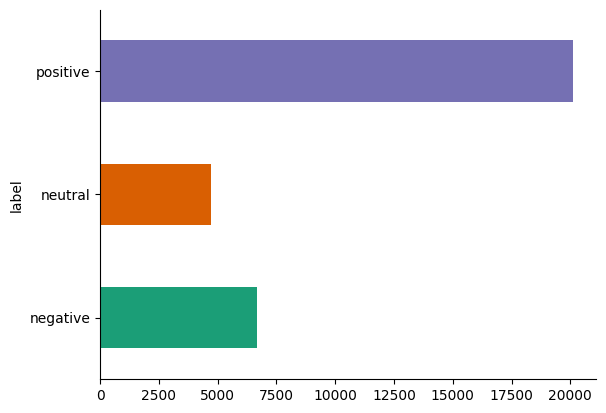

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
preprocessed_data = preprocess_data(data)
preprocessed_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_28288\415774224.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preprocessed_data['label'] = data['label'].replace(MAPPING)


input  label
0                                       √Åo bao ƒë·∫πp ·∫° ! !      1
1                                            Tuy·ªát_v·ªùi !      1
2                            2day ao khong giong trong .      0
3                         M√πi th∆°m , b√¥i l√™n da m·ªÅm da .      1
4                                    V·∫£i ƒë·∫πp , d√†y_d·∫∑n .      1
...                                                  ...    ...
31455                                  Kh√¥ng ƒë√°ng ti·ªÅn .      0
31456                                     Qu·∫ßn r·∫•t ƒë·∫πp .      1
31457                           H√†ng ƒë·∫πp ƒë√∫ng gi√° ti·ªÅn .      1
31458                                  Ch·∫•t v·∫£i kh√° ·ªïn .      1
31459  √°o r·∫•t ok nh√© , v·∫£i m·ªãn , len cao c·ªï n√†y ph·ªëi ...      1

[31460 rows x 2 columns]

## Initialize, tokenize, then train model

In [ ]:
# Getting ready for trainer
phobert, tokenizer, data_collator, tokenized_datasets, _, _ = prepare_for_trainer(df = preprocessed_data, checkpoint = PHOBERT_CHECKPOINT)

tokenized_datasets

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22022 [00:00<?, ? examples/s]

Map:   0%|          | 0/4719 [00:00<?, ? examples/s]

Map:   0%|          | 0/4719 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 22022
    })
    validation: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4719
    })
    test: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4719
    })
})

In [ ]:
# import numpy as np
# import evaluate

# # Setup evaluation
# metric = evaluate.combine(["accuracy", "recall", "precision", "f1", "confusion_matrix"])
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import TrainingArguments, Trainer

# T·∫°o c√°c tham s·ªë ƒë·ªÉ train
output_dir = r"D:\test\sentiment_analysis"
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
)

# T·∫°o object trainer ƒë·ªÉ train
trainer = Trainer(
    phobert,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()
# trainer.save_model(SENTIMENT_ANALYSIS_CHECKPOINT)

## Debug (if necessary)

In [ ]:
trainer.train_dataset[0]

{'content': 'Giao nh·∫ßm h√†ng , ib shop k tr·∫£_l·ªùi üòì üòì üòì .',
 'label': 0,
 'input_ids': [0,
  6460,
  3399,
  119,
  4,
  39913,
  9405,
  1947,
  799,
  3,
  3,
  3,
  5,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [ ]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<s> Giao nh·∫ßm h√†ng, ib shop k tr·∫£_l·ªùi <unk> <unk> <unk>. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [ ]:
trainer.train_dataset[0].keys()

dict_keys(['content', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
trainer.train_dataset.features['label'].names

AttributeError: 'Value' object has no attribute 'names'

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_finish_current_push',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',
 '_nested_gather',
 '_prepare_input',
 '_p

# Specialization

In [13]:
# T∆∞∆°ng t·ª± l·∫ßn train ƒë·∫ßu ti√™n

import pandas as pd

# stock_path = prefix + r"/inputs/df_stock_1804.xlsx"
stock_path = r"..\python\inputs\df_stock_1804.xlsx"
stock_df = pd.read_excel(stock_path)
stock_df

url  \
0    https://cafef.vn/pvoil-len-tieng-vu-he-thong-b...   
1    https://cafef.vn/vinpearl-bao-lai-nam-thu-2-li...   
2    https://cafef.vn/vinpearl-bao-lai-nam-thu-2-li...   
3    https://cafef.vn/dabaco-dbc-dat-muc-tieu-loi-n...   
4    https://cafef.vn/cong-ty-mai-tang-sap-tra-co-t...   
..                                                 ...   
783  https://cafef.vn/chung-khoan-nh-viet-nam-khai-...   
784  https://cafef.vn/chung-khoan-nh-viet-nam-khai-...   
785  https://cafef.vn/chung-khoan-nh-viet-nam-khai-...   
786  https://cafef.vn/chuyen-dong-moi-tu-lien-doanh...   
787  https://cafef.vn/ubcknn-gap-rut-chi-dao-sau-su...   

                       lastmod stockCode  \
0    2024-04-03T17:21:38+07:00       PVO   
1    2024-04-03T19:22:19+07:00       VPL   
2    2024-04-03T19:22:19+07:00       VIC   
3    2024-04-03T16:53:53+07:00       DBC   
4    2024-04-03T15:36:53+07:00       CPH   
..                         ...       ...   
783  2024-03-26T07:14:15+07:00       CEO   
784  2024-03-26T07:14:15+07:00       NHS   
785  2024-03-26T07:14:15+07:00      2023   
786  2024-03-26T08:27:58+07:00      YP2C   
787  2024-03-26T11:24:37+07:00       VND   

                                               content sentiment  
0    PVOIL b·ªã t·∫•n c√¥ng b·∫•t h·ª£p ph√°p, h·ªá th·ªëng c√¥ng ...  negative  
1    Vinpearl c√¥ng b·ªë th√¥ng tin t√¨nh h√¨nh t√†i ch√≠nh...  positive  
2    Vingroup t√°ch Vinpearl v√† th√†nh l·∫≠p c√¥ng ty co...  positive  
3    Dabaco Vietnam Group (DBC) announced their amb...  positive  
4    CTCP Ph·ª•c v·ª• Mai t√°ng H·∫£i Ph√≤ng (MCK: CPH) th√¥...   neutral  
..                                                 ...       ...  
783  √îng Kim Jong Seok ‚Äì CEO Ch·ª©ng kho√°n NH Vi·ªát Na...  positive  
784  Ch·ª©ng kho√°n NH Vi·ªát Nam l√† th√†nh vi√™n thu·ªôc t·∫≠...  positive  
785  NƒÉm 2023, NHSV ghi nh·∫≠n k·∫øt qu·∫£ kinh doanh t√≠c...  positive  
786  Kh·ªüi c√¥ng d·ª± √°n Industrial Centre YP2C thu·ªôc K...   neutral  
787  VNDIRECT th√¥ng b√°o h·ªá th·ªëng giao d·ªãch tr·ª±c tuy...  negative  

[788 rows x 5 columns]

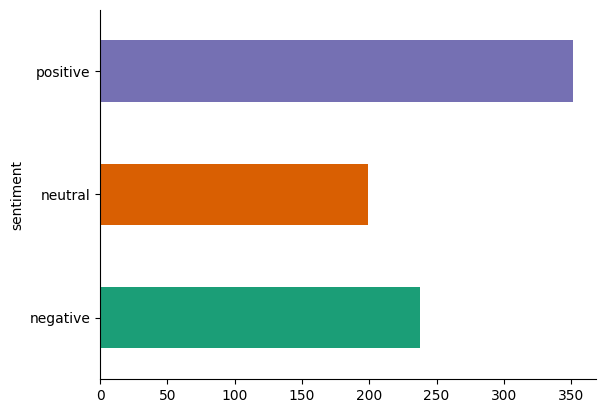

In [14]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
stock_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
stock_df['input'] = stock_df['content']
stock_df['label'] = stock_df['sentiment']

In [16]:
preprocessed_stock_data = preprocess_data(stock_df)
preprocessed_stock_data.dropna()
preprocessed_stock_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_22756\2000335083.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preprocessed_data['label'] = data['label'].replace(INPUT_MAPPING)


input  label
0    PVOIL b·ªã t·∫•n_c√¥ng b·∫•t_h·ª£p_ph√°p , h·ªá_th·ªëng c√¥ng...      0
1    Vinpearl c√¥ng_b·ªë th√¥ng_tin t√¨nh_h√¨nh t√†i_ch√≠nh...      2
2    Vingroup t√°ch Vinpearl v√† th√†nh_l·∫≠p c√¥ng_ty_co...      2
3    Dabaco Vietnam_Group ( DBC ) announced their a...      2
4    CTCP Ph·ª•c_v·ª• Mai_t√°ng H·∫£i_Ph√≤ng ( MCK : CPH ) ...      1
..                                                 ...    ...
783  √îng Kim_Jong_Seok ‚Äì CEO Ch·ª©ng_kho√°n NH Vi·ªát_Na...      2
784  Ch·ª©ng_kho√°n NH Vi·ªát_Nam l√† th√†nh_vi√™n thu·ªôc t·∫≠...      2
785  NƒÉm 2023 , NHSV ghi_nh·∫≠n k·∫øt_qu·∫£ kinh_doanh t√≠...      2
786  Kh·ªüi_c√¥ng d·ª±_√°n Industrial Centre YP2C thu·ªôc K...      1
787  VNDIRECT th√¥ng_b√°o h·ªá_th·ªëng giao_d·ªãch tr·ª±c_tuy...      0

[788 rows x 2 columns]

In [17]:
# Getting ready for trainer
# sa_model_path = prefix + r"/models/phobert_30k_reviews"
# sa_model_path = prefix + r"/trainer_outputs/sentiment_analysis/checkpoint-1770"

sa_model_path = SENTIMENT_ANALYSIS_CHECKPOINT
sa_model, tokenizer, data_collator, tokenized_stock_datasets, raw_stock_datasets , _ = prepare_for_trainer(df = preprocessed_stock_data, 
                                                                                        checkpoint = sa_model_path)

tokenized_stock_datasets

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 551
    })
    validation: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 118
    })
    test: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 119
    })
})

In [18]:
from transformers import TrainingArguments, Trainer

# output_specialization_dir = prefix + r"/trainer_outputs/stock_specialization"

output_specialization_dir = r"D:\test\stock_specialization"

training_stock_args = TrainingArguments(
    output_dir=output_specialization_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
)

trainer_stock = Trainer(
    sa_model,
    training_stock_args,
    train_dataset=tokenized_stock_datasets["train"],
    eval_dataset=tokenized_stock_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [19]:
trainer_stock.train()
# trainer_stock.save_model(SPECIALIZED_MODEL_PATH)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.35388121008872986, 'eval_accuracy': 0.8728813559322034, 'eval_runtime': 29.5138, 'eval_samples_per_second': 3.998, 'eval_steps_per_second': 0.136, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.33060458302497864, 'eval_accuracy': 0.8898305084745762, 'eval_runtime': 28.2095, 'eval_samples_per_second': 4.183, 'eval_steps_per_second': 0.142, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.3087550103664398, 'eval_accuracy': 0.8983050847457628, 'eval_runtime': 28.6075, 'eval_samples_per_second': 4.125, 'eval_steps_per_second': 0.14, 'epoch': 3.0}
{'train_runtime': 1100.8484, 'train_samples_per_second': 1.502, 'train_steps_per_second': 0.049, 'train_loss': 0.2858847865351924, 'epoch': 3.0}


TrainOutput(global_step=54, training_loss=0.2858847865351924, metrics={'train_runtime': 1100.8484, 'train_samples_per_second': 1.502, 'train_steps_per_second': 0.049, 'train_loss': 0.2858847865351924, 'epoch': 3.0})

# Predict with pipeline and test

In [18]:
# Ki·ªÉm ƒë·ªãnh v·ªõi t·∫≠p d·ªØ li·ªáu specialization test 

from transformers import pipeline

sentiment_classifier = pipeline("sentiment-analysis", model = SPECIALIZED_STOCK_CHECKPOINT, tokenizer = PHOBERT_CHECKPOINT)

In [19]:
dataset = raw_stock_datasets["test"]
dataset["input"]

['C·ªï_phi·∫øu PDR ƒë∆∞·ª£c mua r√≤ng 153 t·ª∑ ƒë·ªìng trong tu·∫ßn qua .',
 "V·ªõi nh√† ƒë·∫ßu_t∆∞ gi√°_tr·ªã , c√¥ng_vi·ªác c√≥ v·∫ª ' nh√†n ' h∆°n khi ch·ªâ c·∫ßn t√¨m ƒë∆∞·ª£c c·ªï_phi·∫øu ph√π_h·ª£p ƒë·ªÉ n·∫Øm gi·ªØ d√†i_h·∫°n .",
 '√çt ai bi·∫øt th∆∞∆°ng_v·ª• n√†y th·ª±c_t·∫ø ƒë∆∞·ª£c th√∫c_ƒë·∫©y 5 ‚Äì 6 nƒÉm , tr∆∞·ªõc c·∫£ th·ªã_tr∆∞·ªùng M·ªπ .',
 'MSN l√† 1 trong 9 c·ªï_phi·∫øu ƒë∆∞·ª£c h∆∞·ªüng l·ª£i trong s√≥ng n√¢ng h·∫°ng',
 '√îng Ph·∫°m_Thanh_Ngh·ªã l√† T·ªïng_gi√°m_ƒë·ªëc , ng∆∞·ªùi ƒë·∫°i_di·ªán ph√°p_lu·∫≠t c·ªßa C√¥ng_ty D√¢y ƒë·ªìng Vi·ªát_Nam CFT ‚Äì c√¥ng_ty_con c·ªßa CTCP ƒêi·ªán_l·ª±c Gelex .',
 '·ª¶y_ban Ch·ª©ng_kho√°n Nh√†_n∆∞·ªõc ( UBCKNN ) c≈©ng ƒë√£ l√™n_ti·∫øng c·∫£nh_b√°o v·ªÅ s·ª±_c·ªë c·ªßa VNDirect .',
 'Vinhomes c≈©ng n√¢ng_c·∫•p h·ªá_th·ªëng kinh_doanh online , h∆∞·ªõng t·ªõi n√¢ng cao tr·∫£i nghi·ªám mua h√†ng , minh_b·∫°ch_h√≥a ch√≠nh_s√°ch v√† gi√°_c·∫£ s·∫£n_ph·∫©m , t·∫≠p_trung v√†o vi·ªác tri·ªÉn_khai c√°c d·ª±_√°n m·ªõi ti·ªÅm_nƒÉng ƒë√£ ho√

In [20]:
results = sentiment_classifier(dataset["input"])
results

[{'label': 'LABEL_2', 'score': 0.9935801029205322},
 {'label': 'LABEL_2', 'score': 0.9731795191764832},
 {'label': 'LABEL_2', 'score': 0.48922398686408997},
 {'label': 'LABEL_2', 'score': 0.9927409291267395},
 {'label': 'LABEL_1', 'score': 0.9044064879417419},
 {'label': 'LABEL_0', 'score': 0.6937671899795532},
 {'label': 'LABEL_2', 'score': 0.9730701446533203},
 {'label': 'LABEL_2', 'score': 0.9933551549911499},
 {'label': 'LABEL_1', 'score': 0.819850742816925},
 {'label': 'LABEL_2', 'score': 0.7781935930252075},
 {'label': 'LABEL_1', 'score': 0.874737560749054},
 {'label': 'LABEL_1', 'score': 0.8769955635070801},
 {'label': 'LABEL_0', 'score': 0.9785435795783997},
 {'label': 'LABEL_1', 'score': 0.904969334602356},
 {'label': 'LABEL_0', 'score': 0.9699675440788269},
 {'label': 'LABEL_2', 'score': 0.7722381353378296},
 {'label': 'LABEL_2', 'score': 0.9925342798233032},
 {'label': 'LABEL_2', 'score': 0.6634453535079956},
 {'label': 'LABEL_0', 'score': 0.9791725277900696},
 {'label': 'LA

In [21]:
print(evaluate_model(results, dataset["label"]))
# results_df

{'accuracy': 0.8487394957983193, 'precision': 0.8438629997453526, 'recall': 0.8487394957983193, 'f1': 0.8412092109571101, 'confusion_matrix': array([[34,  3,  0],
       [ 6, 19,  7],
       [ 0,  2, 48]], dtype=int64)}
